In [241]:
import pandas as pd
import pyfolio as pf
import statsmodels.api as sm
import numpy as np
import warnings
warnings.filterwarnings("ignore")

### Import Data

In [242]:
# Get historical crypto price data
cryptoPriceDf = pd.read_csv('data\TradingViewCryptoPrice.csv', index_col=0)
cryptoPriceDf.index = pd.to_datetime(cryptoPriceDf.index)

### Portfolio Construction

In [243]:
def getPortfolioTransactions(TransactionRecords, pairLimit):
    
    # initialize the varaible for extraction
    executedTrades = pd.DataFrame(columns=TransactionRecords.columns)
    mainOpenTransactionIDs = []
    pairOpenTransactionIDs = []

    for _, transaction in TransactionRecords.iterrows():

        # get current TransactionID
        TransactionID = str(transaction['Period No.']) + " " + str(transaction['Pair No.']) + " " + str(transaction['Round Trip No.'])

        # Close Transaction
        if transaction['Open/Close'] == "Close" and TransactionID in mainOpenTransactionIDs:
            executedTrades.loc[len(executedTrades)] = transaction
            mainOpenTransactionIDs.remove(TransactionID)
        # for the pair transaction record 
        elif transaction['Open/Close'] == "Close" and TransactionID in pairOpenTransactionIDs:
            executedTrades.loc[len(executedTrades)] = transaction
            pairOpenTransactionIDs.remove(TransactionID)

        # Open Transaction record
        if len(mainOpenTransactionIDs) < pairLimit and transaction['Open/Close'] == "Open" and TransactionID not in mainOpenTransactionIDs:
            executedTrades.loc[len(executedTrades)] = transaction
            mainOpenTransactionIDs.append(TransactionID)
        # for the pair transaction record
        elif transaction['Open/Close'] == "Open" and TransactionID in mainOpenTransactionIDs:
            executedTrades.loc[len(executedTrades)] = transaction
            pairOpenTransactionIDs.append(TransactionID)
    
    return executedTrades

In [244]:
# Scaling the transactions for each pair to fit the capitalPerPair
def transactionsScaling(executedTrades, capitalPerPair):

    # loop through each round trip of transaction
    for periodNo, pairNo, RoundTripNo in executedTrades.groupby(['Period No.','Pair No.', 'Round Trip No.']).count().index:
        # get the specific round trip
        roundTrip = executedTrades[(executedTrades['Period No.'] == periodNo) & (executedTrades['Pair No.'] == pairNo) & (executedTrades['Round Trip No.'] == RoundTripNo)]

        # calculate the multiplier for this round trip
        openTransaction = roundTrip[roundTrip['Open/Close'] == 'Open']
        multiplier = capitalPerPair / (openTransaction['Price'] * openTransaction['Quantity']).sum()

        # update the quantity with multiplier in order to fit the capitalPerPair
        executedTrades.loc[(executedTrades['Period No.'] == periodNo) & (executedTrades['Pair No.'] == pairNo) & (executedTrades['Round Trip No.'] == RoundTripNo), 'Quantity'] *= multiplier * 2 # *2 for 50% margin

    return executedTrades

### Calculate the return of the portfolio

In [245]:
def calculateCumPnLfPortfolio(executedTrades, cryptoPriceDf): 

    cumPnL = pd.DataFrame()

    # loop through each round trip
    for periodNo, pairNo, RoundTripNo in executedTrades.groupby(['Period No.','Pair No.', 'Round Trip No.']).count().index:

        # get the current round trip
        roundTrip = executedTrades[(executedTrades['Period No.'] == periodNo) & (executedTrades['Pair No.'] == pairNo) & (executedTrades['Round Trip No.'] == RoundTripNo)]

        # get the information of the round trip transaction
        startDate = roundTrip[roundTrip['Open/Close'] == 'Open']['Date'].iloc[0]
        endDate = roundTrip[roundTrip['Open/Close'] == 'Close']['Date'].iloc[0]
        crypto1 = roundTrip[roundTrip['Open/Close'] == 'Open']['Crypto'].iloc[0]
        crypto2 = roundTrip[roundTrip['Open/Close'] == 'Open']['Crypto'].iloc[1]
        crypto1LS = 1 if roundTrip[roundTrip['Open/Close'] == 'Open']['Long/Short'].iloc[0] == 'Long' else -1
        crypto2LS = 1 if roundTrip[roundTrip['Open/Close'] == 'Open']['Long/Short'].iloc[1] == 'Long' else -1
        crypto1Qty = roundTrip[roundTrip['Open/Close'] == 'Open']['Quantity'].iloc[0]
        crypto2Qty = roundTrip[roundTrip['Open/Close'] == 'Open']['Quantity'].iloc[1]

        # Calculate the cumulative P&L of the round trip pair trade and merge to the result dataframe
        crpyto1StartPrice = cryptoPriceDf.loc[startDate, crypto1]
        crpyto2StartPrice = cryptoPriceDf.loc[startDate, crypto2]
        crpyto1cumPnL = (cryptoPriceDf.loc[startDate:endDate, crypto1] - crpyto1StartPrice) * crypto1LS * crypto1Qty
        crpyto2cumPnL = (cryptoPriceDf.loc[startDate:endDate, crypto2] - crpyto2StartPrice) * crypto2LS * crypto2Qty
        cumPnLSeries = crpyto1cumPnL + crpyto2cumPnL
        cumPnLSeries.name = crypto1 + " " + crypto2 + " " + str(periodNo) + " " + str(pairNo) + " " + str(RoundTripNo)
        cumPnL = cumPnL.merge(cumPnLSeries, left_index=True, right_index=True, how="outer")
    
    return cumPnL

In [246]:
def transformCumPnLtoDailyReturn(cumPnL, initialCapital):
    dailyPnL = cumPnL - cumPnL.shift(1)
    totalDailyPnL = dailyPnL.sum(axis=1)
    dailyReturn = (totalDailyPnL.cumsum() + initialCapital).pct_change().fillna(0)
    # cumReturn = (1 + dailyReturn).cumprod() - 1
    return dailyReturn

### Generate the report

In [247]:
# portfolio parameters
initialCapital = 100000
pairLimit = 20
capitalPerPair = initialCapital/pairLimit
spreadThreshold = 3
closeThreshold = 1

In [248]:
# Fundstrat Crypto 300 Index
benchmarkIndex = pd.read_csv('data/FSTOK300.csv', index_col=0)
benchmarkIndex.index = pd.to_datetime(benchmarkIndex.index).date

In [249]:
FamaFrench5factor = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.csv', skiprows=range(3))
FamaFrench5factor = FamaFrench5factor.rename(columns = {'Unnamed: 0':'Date'})
FamaFrench5factor['Date'] = pd.to_datetime(FamaFrench5factor['Date'].apply(str), format='%Y%m%d')
FamaFrench5factor = FamaFrench5factor.set_index('Date')

In [250]:
strategies = ['distance', 'cointegration_All', 'cointegration_categoriesFIlter', 'cointegration_halfLifeFilter 50', 
              'cointegration_halfLifeFilter 100', 'cointegration_halfLifeFilter 500', 'cointegration_halfLifeFilter 1000', 
              'cointegration_KmeanFilter', 'cointegration_Kmean_categoriesFilter']

In [251]:
performanceResult = pd.DataFrame()
strategyDailyReturn = pd.DataFrame()
for strategy in strategies:
    print('Processing strategy [' + strategy + ']')
    # Get Transaction records
    TransactionRecords = pd.read_csv('Transaction/open ' + str(spreadThreshold) + " close " + str(closeThreshold) + '/Transactions_' + strategy + '.csv', index_col=0)
    TransactionRecords['Date'] = pd.to_datetime(TransactionRecords['Date'])
    TransactionRecords = TransactionRecords[TransactionRecords['Period No.'] >= 19]
    TransactionRecords = TransactionRecords.sort_values(['Date', 'Open/Close', 'Period No.', 'Pair No.', 'Round Trip No.', 'Crypto']).reset_index(drop=True)

    # get the daily Return
    executedTrades = getPortfolioTransactions(TransactionRecords, pairLimit)
    executedTrades = transactionsScaling(executedTrades, capitalPerPair)
    cumPnL = calculateCumPnLfPortfolio(executedTrades, cryptoPriceDf)
    dailyReturn = transformCumPnLtoDailyReturn(cumPnL, initialCapital)

    # get the result
    benchmark_rets = benchmarkIndex.loc[TransactionRecords['Date'].min():, 'close'].pct_change().fillna(0)
    performance = pd.concat([pf.timeseries.perf_stats(dailyReturn), pf.timeseries.calc_distribution_stats(dailyReturn)])
    alpha_beta = pf.timeseries.alpha_beta(dailyReturn, benchmark_rets)
    performance = pd.concat([performance, pd.Series({'Alpha (CAPM)': alpha_beta[0], 'Beta': alpha_beta[1]})])

    # get Fama-French 5 factor alpha
    dailyReturn.name = 'Return'
    temp_df = pd.merge(dailyReturn, FamaFrench5factor, how='inner', left_index=True, right_index=True)
    Y = temp_df['Return'] - temp_df['RF']
    X = temp_df.loc[:, ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    ff5factorsAlpha = results.params[0]
    performance = pd.concat([performance, pd.Series({'Alpha (Fama-French 5 factors)': ff5factorsAlpha})])

    performanceResult[strategy] = performance
    strategyDailyReturn[strategy] = dailyReturn

Processing strategy [distance]


Processing strategy [cointegration_All]
Processing strategy [cointegration_categoriesFIlter]
Processing strategy [cointegration_halfLifeFilter 50]
Processing strategy [cointegration_halfLifeFilter 100]
Processing strategy [cointegration_halfLifeFilter 500]
Processing strategy [cointegration_halfLifeFilter 1000]
Processing strategy [cointegration_KmeanFilter]
Processing strategy [cointegration_Kmean_categoriesFilter]


In [252]:
# Combine strategy
strategyDailyReturn = strategyDailyReturn.fillna(0)
dailyReturn = (strategyDailyReturn['cointegration_halfLifeFilter 1000'] + strategyDailyReturn['cointegration_KmeanFilter'] + strategyDailyReturn['cointegration_Kmean_categoriesFilter'])/3
performance = pd.concat([pf.timeseries.perf_stats(dailyReturn), pf.timeseries.calc_distribution_stats(dailyReturn)])
alpha_beta = pf.timeseries.alpha_beta(dailyReturn , benchmark_rets)
performance = pd.concat([performance, pd.Series({'Alpha (CAPM)': alpha_beta[0], 'Beta': alpha_beta[1]})])

# get Fama-French 5 factor alpha
dailyReturn.name = 'Return'
temp_df = pd.merge(dailyReturn, FamaFrench5factor, how='inner', left_index=True, right_index=True)
Y = temp_df['Return'] - temp_df['RF']
X = temp_df.loc[:, ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
ff5factorsAlpha = results.params[0]
performance = pd.concat([performance, pd.Series({'Alpha (Fama-French 5 factors)': ff5factorsAlpha})])

performanceResult['Combined strategy'] = performance
strategyDailyReturn['Combined strategy'] = dailyReturn

In [253]:
# add benchmark to the result
performance = pd.concat([pf.timeseries.perf_stats(benchmark_rets), pf.timeseries.calc_distribution_stats(benchmark_rets)])
alpha_beta = pf.timeseries.alpha_beta(benchmark_rets, benchmark_rets)
performance = pd.concat([performance, pd.Series({'Alpha (CAPM)': alpha_beta[0], 'Beta': alpha_beta[1]})])

# get Fama-French 5 factor alpha
benchmark_rets.name = 'Return'
temp_df = pd.merge(benchmark_rets, FamaFrench5factor, how='inner', left_index=True, right_index=True)
Y = temp_df['Return'] - temp_df['RF']
X = temp_df.loc[:, ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
ff5factorsAlpha = results.params[0]
performance = pd.concat([performance, pd.Series({'Alpha (Fama-French 5 factors)': ff5factorsAlpha})])


performanceResult['Benchmark'] = performance
strategyDailyReturn['Benchmark'] = benchmark_rets

strategyDailyReturn = strategyDailyReturn.fillna(0)

In [254]:
performanceResult

,distance,cointegration_All,cointegration_categoriesFIlter,cointegration_halfLifeFilter 50,cointegration_halfLifeFilter 100,cointegration_halfLifeFilter 500,cointegration_halfLifeFilter 1000,cointegration_KmeanFilter,cointegration_Kmean_categoriesFilter,Combined strategy,Benchmark
Annual return,-0.077736,0.517427,0.566620,0.254277,0.440405,0.538261,0.543050,0.379659,0.352027,0.327423,-0.412544
Cumulative returns,-0.171800,1.513656,1.589031,0.345391,0.751407,1.444341,1.590534,0.891342,0.757187,0.934345,-0.563774
Annual volatility,0.692978,0.281688,0.268717,0.144655,0.189765,0.282243,0.270772,0.200662,0.179367,0.178186,0.591374
Sharpe ratio,0.234825,1.621001,1.804292,1.638064,2.018962,1.666369,1.736916,1.704756,1.771794,1.679105,-0.599936
Calmar ratio,-0.100171,2.977126,3.470635,3.276769,4.457234,3.174931,3.356681,4.323229,4.405356,3.570415,-0.604016
Stability,0.173687,0.935421,0.955628,0.916687,0.956907,0.951457,0.951766,0.958576,0.967650,0.963582,0.173767
Max drawdown,-0.776029,-0.173801,-0.163261,-0.077600,-0.098807,-0.169535,-0.161782,-0.087818,-0.079909,-0.091705,-0.683002
Omega ratio,1.051891,1.452222,1.527796,1.469142,1.602989,1.473442,1.504389,1.410723,1.442166,1.435968,0.894743
Sortino ratio,0.326885,2.587242,3.007947,2.952465,3.178624,2.680807,2.839985,2.696862,2.828309,2.691463,-0.802331
Skew,-0.212707,0.883086,1.447722,2.132619,0.076998,1.159254,1.157613,0.254006,0.239454,0.388383,-0.283672


In [255]:
performanceResult.to_excel('Report/open ' + str(spreadThreshold) + " close " + str(closeThreshold) + '/portfolio_performance.xlsx')

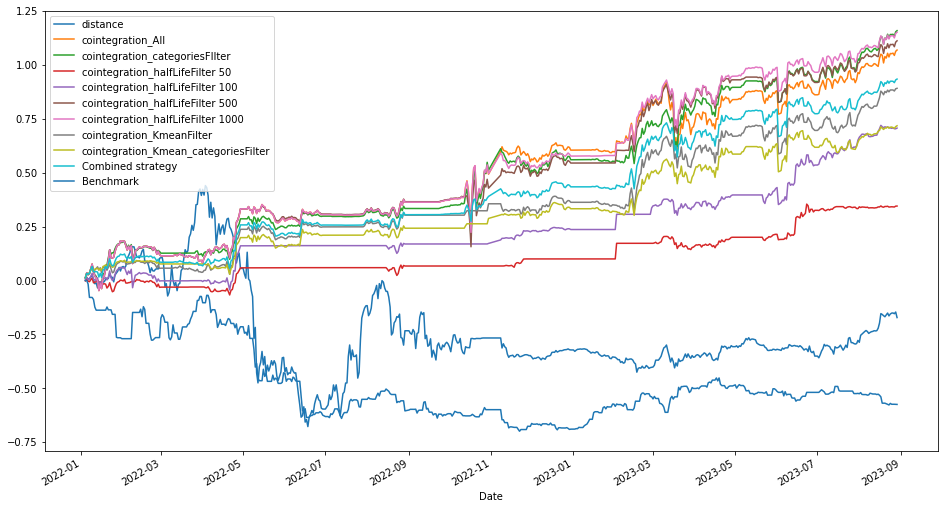

In [256]:
strategyCumReturn = (1 + strategyDailyReturn).cumprod() - 1
plot = strategyCumReturn.plot(figsize=(16, 9))
fig = plot.get_figure()
fig.savefig("Report/open " + str(spreadThreshold) + " close " + str(closeThreshold) + "/cumulative_return.png")


In [257]:
# pf.create_full_tear_sheet(
#     returns=dailyReturn,
#     benchmark_rets= benchmark_rets
# )